# Composing and fitting distributions with Carl

Gilles Louppe, January 2016.

This notebook introduces the `carl.distributions` module. It illustrates how distributions can be defined and composed, and how their parameters can be fit to data. 

*Disclaimer*: This module is meant to be a proof-of-concept that a full Python+Theano based RooFit equivalent could reallistically be achieved. At the moment, the module remains very experimental and should not be used in production.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Base API

All base distributions from `carl.distributions` implement the `DistributionMixin` interface, providing the following methods:

- `pdf(X)` for computing the probability density at `X`
- `nnlf(X)` for computing `-log(pdf(X))`
- `cdf(X)` for computing the cumulative density at `X`
- `rvs(n_samples)` for sampling data
- `ppf(p)` for computing the `p`-th quantile

Parameters of a distribution (e.g., the location `mu` of a normal distribution) are specified at initialization.

In [2]:
from carl.distributions import Normal
p = Normal(mu=1.0, sigma=2.0)

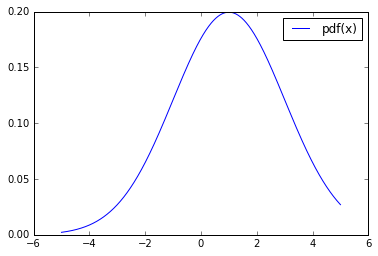

In [3]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, 
         p.pdf(reals.reshape(-1, 1)),  # X is expected to be a 2D matrix of shape n_samples x n_dimensions
         label="pdf(x)")
plt.legend(loc="best")

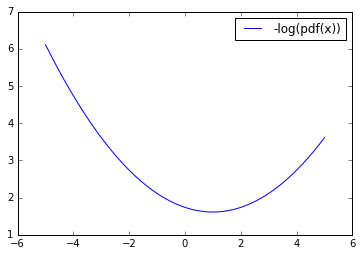

In [4]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.nnlf(reals.reshape(-1, 1)), label="-log(pdf(x))")
plt.legend(loc="best")

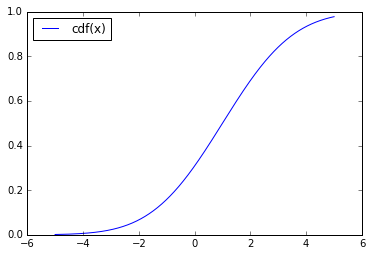

In [5]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.cdf(reals.reshape(-1, 1)), label="cdf(x)")
plt.legend(loc="best")

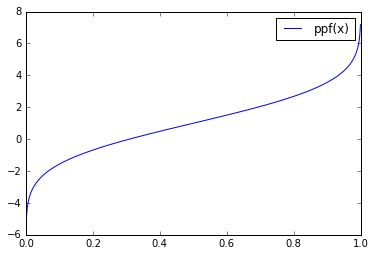

In [6]:
reals = np.linspace(0, 1, num=1000)
plt.plot(reals, p.ppf(reals.reshape(-1, 1)), label="ppf(x)")
plt.legend(loc="best")

In [7]:
p.rvs(n_samples=10000)

array([[ 1.5942845 ],
       [ 0.2629067 ],
       [ 1.20083981],
       ..., 
       [ 0.89477011],
       [ 0.55412731],
       [ 0.49569298]])

## Advanced API

Parameters of a distribution can be  specified either as scalars or as abitrary Theano symbolic expressions, as shown below. Under the hood, if a parameter is specified as a scalar, then it is automatically embedded into a Theano shared variable. 

In [8]:
a = theano.shared(1.0, name="a")
b = T.constant(0.5, name="b")
p = Normal(mu=a * b, sigma=2.0)

In [9]:
# Parameters are Theano symbolic expressions
print(p.mu, type(p.mu))
print(p.sigma, type(p.sigma))  # sigma=2.0 was embedded into a shared variable

Elemwise{mul,no_inplace}.0 <class 'theano.tensor.var.TensorVariable'>
sigma <class 'theano.tensor.sharedvar.ScalarSharedVariable'>


By construction `p.mu` is a Theano symbolic expression which depends on several inputs, in this case `a` and `b`. Base inputs of all expressions specified at initialization are themselves parameters of `p` if they are Theano shared variables. In the end, all required (hyper-)parameters are stored in `p.parameters_` while constants are stored in `p.constants_`.

In [10]:
p.parameters_  # all input parameters (note that mu is not part of those!)

{sigma, a}

In [11]:
p.constants_   # all input constants`

{TensorConstant{0.5}}

Additionally, parameter expressions can be defined in terms of free Theano variables that are not (yet) tied to any value. These auxiliary inputs will need to be passed at evaluation. All required extra inputs are stored in `p.observeds_`.

In [12]:
a = T.dmatrix(name="a")  # free input to be specified at evauation
b = theano.shared(-1.0, name="b")
c = theano.shared(1.0, name="c")
p = Normal(mu=a*b + c)

In [13]:
p.parameters_

{c, sigma, b}

In [14]:
p.constants_

set()

In [15]:
p.observeds_

{a}

In [16]:
p.pdf(X=np.array([[0.0], [0.0]]),
      a=np.array([[1.0], [2.0]]))  # specify the auxiliary input `a` at evaluation

array([ 0.39894228,  0.24197072])

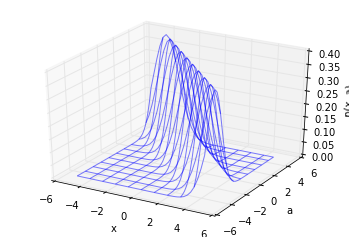

In [17]:
# Plot pdf(x, a)
import mpl_toolkits.mplot3d.axes3d as axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

Xs = np.arange(-5, 5, 0.25)
As = np.arange(-5, 5, 0.25)
Xs, As = np.meshgrid(Xs, As)

Ps = p.pdf(X=Xs.reshape(-1, 1), 
           a=As.reshape(-1, 1))
Ps = Ps.reshape(Xs.shape)

ax.plot_wireframe(Xs, As, Ps, rstride=4, cstride=4, alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("a")
ax.set_zlabel("p(x, a)")

plt.show()

## Composing mixtures

Mixtures distributions can be composed from a set of other distribution objects, as long as they implement the `DistributionMixin` API.

Weights assigned to components are provided as a list of scalars or as a list of Theano expressions. Note that weights are automatically normalized such that they sum to 1.

In [18]:
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

g = theano.shared(0.05, name="g") 
p = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])

In [19]:
p.parameters_  # union of all component parameters + g

{mu, g, mu, mu, sigma, sigma, sigma}

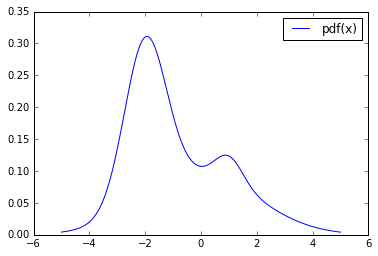

In [20]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.pdf(reals.reshape(-1, 1)), label="pdf(x)")
plt.legend()

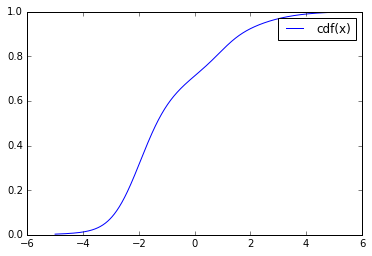

In [21]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p.cdf(reals.reshape(-1, 1)), label="cdf(x)")
plt.legend()

In [22]:
p.weights

[Elemwise{true_div,no_inplace}.0,
 Elemwise{true_div,no_inplace}.0,
 Elemwise{true_div,no_inplace}.0]

In [23]:
p.compute_weights()

array([ 0.475,  0.475,  0.05 ])

## Fitting parameters to data

Finally, distribution objects also implement a `fit` method for fitting through maximum likelihood all parameters from `p.parameters_` 

The Theano expression engine is used to symbolically derive the gradient of the objective function with respect to the parameters. This gradient function is then used to guide to underlying optimization algorithm. If needed, bounds and constraints can also be specified.

In [24]:
# Target distribution
p0 = Mixture(components=[Normal(mu=1.0, sigma=1.0), Normal(mu=4.0, sigma=1.0)],
             weights=[0.7, 0.3])

# Fit components[0].mu and mixture weights
p1 = Mixture(components=[Normal(mu=0.0, sigma=T.constant(1.0)), 
                         Normal(mu=T.constant(4.0), sigma=T.constant(1.0))])
p1.parameters_

{param_w0, mu}

In [25]:
X = p0.rvs(10000)
p1.fit(X)

Mixture(components=[Normal(mu=mu, random_state=None, sigma=TensorConstant{1.0}), Normal(mu=TensorConstant{4.0}, random_state=None, sigma=TensorConstant{1.0})],
    optimizer=None, random_state=None,
    weights=[Elemwise{true_div,no_inplace}.0, Elemwise{true_div,no_inplace}.0])

In [26]:
p1.components[0].mu.eval()

array(0.966095888708045)

In [27]:
p1.compute_weights()

array([ 0.70528593,  0.29471407])

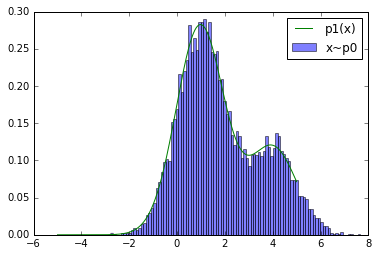

In [28]:
reals = np.linspace(-5, 5, num=1000)
plt.hist(X.ravel(), bins=100, normed=1, alpha=0.5, label="x~p0")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label="p1(x)")
plt.legend()